<a href="https://colab.research.google.com/github/kirilllL2/PopIT.FoodOrder/blob/master/LR_1_Konnov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⚡ Коннов Кирилл. Группа 6313-020302D. Лабораторная работа №1⚡

# Конфигурация

## Используемые библиотеки

In [145]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional

## Конфиг

### TODO: 

- def function
- def function_str
- FUNCTION_INPUTS (кол-во переменных)

In [146]:
FUNCTION_INPUTS = 8                                                             # Количество переменных в функции
FUNCTION_OUTPUTS = 1                                                            # Количество выходных данных

CONST_TEST_COEFFICIENT = 0.8                                                    # коэффициент обучающих случаев
CONST_ETA = 0.75                                                                # коэффициент обучения
CONST_MAX_WEIGHT: float = 5                                                     # максимум случайного веса
CONST_BIAS_NEURON = 1                                                           # вес биаса, назначаемый в начале обучения
CONST_GENERATIONS = 20                                                          # количество эпох обучения нейросети
CONST_MAX_FUNCTIONS = int(math.pow(2, FUNCTION_INPUTS))                         # количество всех случаев
CONST_IMAGES_TRAIN = int(CONST_TEST_COEFFICIENT * CONST_MAX_FUNCTIONS)          # количество обучающих случаев
CONST_IMAGES_TEST = CONST_MAX_FUNCTIONS - CONST_IMAGES_TRAIN                    # количество тестирующихся случаев

TRAIN_FILE_NAME = 'data/training_data.txt'                                      # Названия файла с обучающей выборкой
TEST_FILE_NAME = 'data/test_data.txt'                                           # Название файла с тестирующей выборкой
NETWORK_FILE = 'Perceptron/network.txt'                                         # Названия файла для сохранения информации об обученном персептроне

def function(i: np.ndarray):                                                    
    return int((((i[0] or i[4]) and i[5]) or (i[1] or i[2] or i[7]) and (i[3] or i[5])) and (i[6] or i[4] and i[1] or i[7]))

def function_str():                                                               
    return '(((a or e) and f) or (b or c or h) and (d or f)) and (g or e and b or h)'

# Генерация данных для обучения и тестирования

**Тестовые** данные кладутся в файл `data/test_data.txt`

Данные для **обучения** кладутся в файл `data/training_data.txt`

In [147]:
inputs = []
with open(TRAIN_FILE_NAME, 'w') as tr, open(TEST_FILE_NAME, 'w') as tst:
    for i in range(CONST_MAX_FUNCTIONS):
        inputs.append(' '.join((f"{i:{FUNCTION_INPUTS}b}".replace(' ', '0'))))
    random.shuffle(inputs)

    for _ in range(CONST_IMAGES_TRAIN - 1):
        tr.write(f"{inputs.pop()}\n")
    tr.write(f"{inputs.pop()}")
    for _ in range(CONST_IMAGES_TEST - 1):
        tst.write(f"{inputs.pop()}\n")
    tst.write(f"{inputs.pop()}")

# Исходники

In [148]:
# Данные о персептроне
class TPerceptron:
    def __init__(self):
        self.n_inp: Optional[int] = FUNCTION_INPUTS
        self.n_out: Optional[int] = FUNCTION_OUTPUTS
        self.w = np.empty((FUNCTION_INPUTS + 1, FUNCTION_OUTPUTS), dtype=float)
        self.inp = np.empty(FUNCTION_INPUTS, dtype=int)
        self.out = np.empty(FUNCTION_OUTPUTS, dtype=float)

# Входные данные с ответом
class TBaseRecord:
    def __init__(self):
        self.X = np.empty(FUNCTION_INPUTS, dtype=float)
        self.Y = np.empty(FUNCTION_OUTPUTS, dtype=float)

# Набор тестирующих данных
class TBase:
    def __init__(self):
        self.images = [TBaseRecord() for _ in range(CONST_IMAGES_TRAIN)]

# Персептрон
class Perceptron:
    net = TPerceptron()
    tbase = TBase()
    error: Optional[float] = None
    temp: Optional[float] = None
    delta: Optional[float] = None
    correct: Optional[float] = None

    def init_all(self):
        for i in range(self.net.n_inp + 1):
            for j in range(self.net.n_out):
                self.net.w[i, j] = CONST_MAX_WEIGHT * random.random()

    def get_data_base(self):
        with open(TRAIN_FILE_NAME, 'r') as f:
            train_inputs = [[int(x) for x in lst.rstrip().split()] for lst in f.readlines()]
            for i in range(CONST_IMAGES_TRAIN):
                for j in range(self.net.n_inp):
                    self.tbase.images[i].X[j] = train_inputs[i][j]
                self.tbase.images[i].Y[0] = function(self.tbase.images[i].X)

    def save_net(self):
        with open(NETWORK_FILE, 'w') as data:
            data.write('Количество входных данных: ' + str(self.net.n_inp))
            data.write('\nКоличество выходных данных: ' + str(self.net.n_out))
            for i in range(self.net.n_inp + 1):
                res = ''
                for j in range(self.net.n_out):
                    res += "{0:.7f}".format(self.net.w[i, j]) + '   '
                if i == 0:
                    data.write(f'\nВес биаса: {res}')
                else:
                    data.write(f'\nВес {i} нейрона: {res}')

    @staticmethod
    def sigmoid(z: float) -> float:
        return 1 / (1 + math.exp(-z))

# Программа

## Обучение персептрона

In [149]:
perc = Perceptron()
perc.init_all()
perc.get_data_base()

with open(TEST_FILE_NAME, 'r') as f:
    test_inputs = [[int(x) for x in lst.rstrip().split()] for lst in f.readlines()]

train_accuracy_list = []
test_accuracy_list = []
for gen in range(1, CONST_GENERATIONS + 1):
    # цикл по обучающей выборке
    correct_train_answers = 0
    for i in range(CONST_IMAGES_TRAIN):
        # передача очередного образа на входы сети
        for j in range(perc.net.n_inp):
            perc.net.inp[j] = perc.tbase.images[i].X[j]
        for k in range(perc.net.n_out):
            # состояние очередного нейрона
            temp = CONST_BIAS_NEURON * perc.net.w[0, k]
            for j in range(1, perc.net.n_inp + 1):
                temp += perc.net.inp[j - 1] * perc.net.w[j, k]
            perc.net.out[k] = perc.sigmoid(temp)
            # накопление ошибки
            perc.delta = perc.tbase.images[i].Y[k] - perc.net.out[k]
            if perc.delta < 0.5:
                correct_train_answers += 1
            # обучение по дельта-правилу Розенблатта
            perc.net.w[0, k] += CONST_ETA * CONST_BIAS_NEURON * perc.delta
            for j in range(1, perc.net.n_inp + 1):
                perc.net.w[j, k] += CONST_ETA * perc.net.inp[j - 1] * perc.delta
    train_accuracy_list.append(correct_train_answers/CONST_IMAGES_TRAIN)

    correct_test_answers = 0
    for i in range(CONST_IMAGES_TEST):
        perc.net.inp = test_inputs[i]
        correct = function(perc.net.inp)
        # ответ выдает нейросеть
        for t in range(perc.net.n_out):
            temp = CONST_BIAS_NEURON * perc.net.w[0, t]
            for j in range(1, perc.net.n_inp + 1):
                temp += perc.net.inp[j - 1] * perc.net.w[j, t]
            perc.net.out[t] = perc.sigmoid(temp)
        if abs(correct - perc.net.out[t]) < 0.5:
            correct_test_answers += 1
    test_accuracy_list.append(correct_test_answers/CONST_IMAGES_TEST)

perc.save_net()

## Вывод результатов

In [150]:
print(f'Функция: {function_str()}')
print(f'Выполняется {CONST_IMAGES_TRAIN} операции на обучение')
print(f'Выполняется {CONST_IMAGES_TEST} операции на тестирование')
print(f'Количество эпох: {CONST_GENERATIONS}')

Функция: (((a or e) and f) or (b or c or h) and (d or f)) and (g or e and b or h)
Выполняется 204 операции на обучение
Выполняется 52 операции на тестирование
Количество эпох: 20


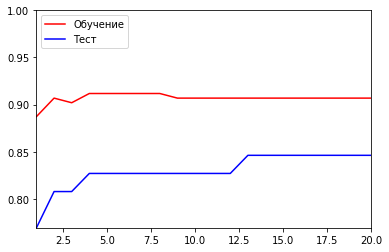

In [151]:
plt.plot(range(1, CONST_GENERATIONS + 1), train_accuracy_list, 'r')
plt.plot(range(1, CONST_GENERATIONS + 1), test_accuracy_list, 'b')
plt.axis([1, CONST_GENERATIONS, min(train_accuracy_list + test_accuracy_list), 1])
plt.ylabel = 'Корректность'
plt.xlabel = 'Эпоха'
plt.legend(['Обучение', 'Тест'], loc=2)
plt.show()

In [152]:
print('ВОПРОС               ВЕРНЫЙ ОТВЕТ       ОТВЕТ')

for i in range(CONST_IMAGES_TEST):
    for j in range(perc.net.n_inp):
        perc.net.inp[j] = test_inputs[i][j]
    correct = function(perc.net.inp)
    # ответ выдает нейросеть
    for t in range(perc.net.n_out):
        temp = CONST_BIAS_NEURON * perc.net.w[0, t]
        for j in range(1, perc.net.n_inp + 1):
            temp += perc.net.inp[j - 1] * perc.net.w[j, t]
        perc.net.out[t] = perc.sigmoid(temp)
    # выдача результатов
    inputs = ' '.join(str(x) for x in list(perc.net.inp))
    print(f'{inputs}        {correct}                  {perc.net.out[0]:.7f}')

ВОПРОС               ВЕРНЫЙ ОТВЕТ       ОТВЕТ
0 1 1 0 0 1 0 0        0                  0.1419460
1 0 1 1 1 1 1 0        1                  0.9996487
0 1 0 1 1 1 1 1        1                  0.9999999
1 0 1 0 0 0 0 0        0                  0.0000259
1 0 0 1 0 1 0 0        0                  0.7560427
1 1 1 0 0 0 0 1        0                  0.0202078
0 1 0 0 0 1 1 0        1                  0.8781988
1 0 0 0 1 0 0 1        0                  0.0645646
0 1 1 0 1 0 0 1        0                  0.6310227
1 0 0 1 0 1 1 1        1                  0.9999561
0 1 1 0 0 0 1 1        0                  0.8145147
1 0 0 1 1 1 1 0        1                  0.9996225
1 1 0 0 1 1 1 0        1                  0.9665914
0 0 0 1 1 0 0 0        0                  0.4813144
0 1 0 1 0 0 0 1        1                  0.9759017
0 1 1 0 1 0 1 1        0                  0.9876698
0 1 0 0 1 1 1 0        1                  0.9924540
1 0 1 1 0 0 0 0        0                  0.0118833
0 0 0 0 0 0 1 0   